# Categories -> Pageviews

### Anton Mishchuk, Oleh Kariuk, Volodymyr Byno, Volodymyr Maletskyi, Denis Porplenko

### Motivation
There are lots of articles in UA wiki that are not translated into EN (or other languages). When volunteers want to translate an article it is quite difficult for them to understand where to start. We are going to build a system that will recommend a UA article that will be likely quite popular in a target language. 

### Problem statement
Create a system that can recommend UA article which, after being translated, will be popular (in terms of page views) in EN wiki. (Actually, we can choose any target language, not only English)


### Approach
We assume that the popularity of articles correlates with their categories. Knowing which categories more popular we can recommend the corresponding articles.
The following steps need to be implemented:

1. For each UA page extract categories.
2. For each translated UA page fetch pageviews of corresponding EN pageviews in 2018.
3. Build an ML model that uses “UA categories” as input and “EN pageviews” as output
4. Predict “EN pageviews” for UA pages without translation.
5. Rank pages based on the pageviews.


### Data
UA wiki (https://dumps.wikimedia.org/ukwiki/20190420/):
    
- ukwiki-20190420-page.sql - pages
- ukwiki-20190420-category.sql.gz - contains categories for articles
- ukwiki-20190420-categorylinks.sql - links from pages to categories
- ukwiki-20190420-langlinks.sql - links to other languages

EN wiki (https://dumps.wikimedia.org/enwiki/20190420/):
- enwiki-20190420-page.sql.gz -  pages


### Data preprocessing
SQL dumps were imported into MariaDB and the following SQL was executed

```sql
SELECT DISTINCT
uk_page.page_id as uk_page_id,
uk_page.page_title as uk_page_title,
uk_page.page_touched as uk_page_touched,
en_page.page_id as en_page_id,
en_page.page_title as en_page_title, 
category.cat_id as cat_id,
category.cat_title as cat_title,  
category.cat_pages as cat_pages
FROM uk_page
JOIN categorylinks ON uk_page.page_id = categorylinks.cl_from AND categorylinks.cl_type = 'page'
JOIN category ON categorylinks.cl_to = category.cat_title 
LEFT JOIN langlinks ON uk_page.page_id = langlinks.ll_from AND (langlinks.ll_lang = 'en' OR langlinks.ll_lang IS NULL)
LEFT JOIN en_page ON langlinks.ll_title = en_page.page_title AND (en_page.page_namespace = 0 OR en_page.page_namespace IS NULL)
WHERE uk_page.page_is_redirect = 0 AND uk_page.page_namespace = 0 AND uk_page.page_is_new = 0
AND category.cat_title NOT LIKE '%:%' 
AND category.cat_title NOT LIKE "Незавершені_%" 
AND category.cat_title NOT LIKE "Статті_%"
AND category.cat_title NOT LIKE "%_статті%" 
AND category.cat_title NOT LIKE "Сторінки_%"
AND category.cat_title NOT LIKE "Всі_сторінки_%" 
AND category.cat_title NOT LIKE "%_за_алфавітом"
AND category.cat_title NOT LIKE "Файли_%"
AND category.cat_title NOT LIKE "Зображення_%"
AND category.cat_title NOT LIKE "User_%"
ORDER BY uk_page.page_id
```

The results were saved in 'pages.csv' file.

In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm 
pd.set_option('display.max_colwidth', -1)

In [2]:
zip_file = zipfile.ZipFile('pages.csv.zip')
df = pd.read_csv(zip_file.open('pages.csv'), error_bad_lines=False)
df.head()

b'Skipping line 329704: expected 8 fields, saw 9\n'
b'Skipping line 2455322: expected 8 fields, saw 9\nSkipping line 2455323: expected 8 fields, saw 9\nSkipping line 2455324: expected 8 fields, saw 9\nSkipping line 2455325: expected 8 fields, saw 9\n'
b'Skipping line 3086952: expected 8 fields, saw 9\nSkipping line 3086953: expected 8 fields, saw 9\n'
b'Skipping line 3224952: expected 8 fields, saw 9\n'


,uk_page_id,uk_page_title,uk_page_touched,en_page_id,en_page_title,cat_id,cat_title,cat_pages
0,13,Географія,20190417081543,18963910.0,Geography,3925.0,Географія,35.0
1,13,Географія,20190417081543,18963910.0,Geography,8892.0,МГЕ,9748.0
2,584,Атом,20190417081543,902.0,Atom,22848.0,Атоми,16.0
3,584,Атом,20190417081543,902.0,Atom,2448.0,Базові_поняття_фізики,121.0
4,584,Атом,20190417081543,902.0,Atom,6952725.0,Основні_поняття_хімії,29.0


In [3]:
df.shape

(3310792, 8)

In [4]:
categories_for_pages = {}
for i, row in df.iterrows():
    uk_page_id = row['uk_page_id']
    if uk_page_id in categories_for_pages:
        categories_for_pages[uk_page_id].append(str(row['cat_title']))
    else:
        categories_for_pages[uk_page_id] = [str(row['cat_title'])]

In [5]:
pages = df.groupby(['uk_page_id', 'uk_page_title']).sum().reset_index()
pages = pages[['uk_page_id', 'uk_page_title']]
uk_to_en = df.groupby(['uk_page_id', 'en_page_id']).sum().reset_index()
uk_to_en = uk_to_en[['uk_page_id', 'en_page_id']]
pages = pd.merge(pages, uk_to_en, on='uk_page_id', how='left')
pages.head()

,uk_page_id,uk_page_title,en_page_id
0,13,Географія,18963910.0
1,584,Атом,902.0
2,585,Мільярд,1136363.0
3,586,Ядро,NaN
4,587,Мільйон,1045999.0


In [6]:
pages['categories'] = pages.apply(lambda row: " ".join(categories_for_pages[row['uk_page_id']]), axis=1)

I'm just joined all the categories into one string "categories".
See below.

In [7]:
pages.head(10)

,uk_page_id,uk_page_title,en_page_id,categories
0,13,Географія,18963910.0,Географія МГЕ
1,584,Атом,902.0,Атоми Базові_поняття_фізики Основні_поняття_хімії
2,585,Мільярд,1136363.0,Натуральні_числа
3,586,Ядро,NaN,Багатозначні_терміни Всі_сторінки_неоднозначності Всі_сторінки_неоднозначності_статей
4,587,Мільйон,1045999.0,Натуральні_числа
5,588,Хімія,5180.0,Природничі_науки Хімія
6,590,Діаметр,8007.0,Довжина Класична_геометрія Метрична_геометрія
7,591,Метр,18947.0,Одиниці_СІ Одиниці_довжини Фізичні_одиниці
8,592,Біологія,9127632.0,Біологія Природничі_науки
9,600,Коло,6220.0,Алгебричні_криві Кола Конічні_перетини Криві Планіметрія Стереометрія


In [8]:
pages.shape

(849146, 4)

### Pageviews data

Pageviews for EN pages were fetched using Wikimedia REST API 
https://wikimedia.org/api/rest_v1/#/Pageviews%20data/get_metrics_pageviews_per_article__project___access___agent___article___granularity___start___end_
The results are stored in 'pageviews.csv' file

In [9]:
zip_file = zipfile.ZipFile('pageviews.csv.zip')
pageviews = pd.read_csv(zip_file.open('pageviews.csv'))
pageviews.head()

,en_page_id,en_page_title,2018010100,2018020100,2018030100,2018040100,2018050100,2018060100,2018070100,2018080100,2018090100,2018100100,2018110100,2018120100,2019010100,2019020100,2019030100,2019040100,2019050100,2019060100
0,15736354,Saint-Victor-de-Buthon,50,21,23,20,24,17,32,21,18,25,25,20,17,26,19,15,21,19
1,15736357,Sainville,76,22,41,27,28,43,52,45,40,64,23,27,47,40,27,49,34,29
2,15736358,Sancheville,44,20,23,14,17,21,25,23,19,21,24,24,33,23,34,34,22,17
3,15736360,Sandarville,42,16,20,11,19,20,10,26,26,14,9,26,17,25,11,23,18,16
4,15736366,Saumeray,39,13,14,19,12,16,16,15,20,24,11,27,34,23,18,22,13,17


In [10]:
pageviews['views_in_2018'] = pageviews['2018070100'] + pageviews['2018080100'] + pageviews['2018090100'] + pageviews['2018100100'] + pageviews['2018110100'] + pageviews['2018120100']
pageviews['views_in_2019'] = pageviews['2019010100'] + pageviews['2019020100'] + pageviews['2019030100'] + pageviews['2019040100'] + pageviews['2019050100'] + pageviews['2019060100']
pageviews['log_views_in_2018'] = np.log(pageviews['views_in_2018']+1) / np.log(10)
pageviews['log_views_in_2019'] = np.log(pageviews['views_in_2019']+1) / np.log(10)
pageviews2018 = pageviews[['en_page_id', 'views_in_2018', 'views_in_2019', 'log_views_in_2018', 'log_views_in_2019']]
pageviews2018.head()

,en_page_id,views_in_2018,views_in_2019,log_views_in_2018,log_views_in_2019
0,15736354,141,117,2.152288,2.071882
1,15736357,251,226,2.401401,2.356026
2,15736358,136,163,2.136721,2.214844
3,15736360,111,110,2.049218,2.045323
4,15736366,113,127,2.056905,2.107210


In [11]:
pageviews['views_in_2018'].mean(), pageviews['views_in_2018'].median(), pageviews['views_in_2018'].max()

(29581.734261815483, 750.0, 30204976)

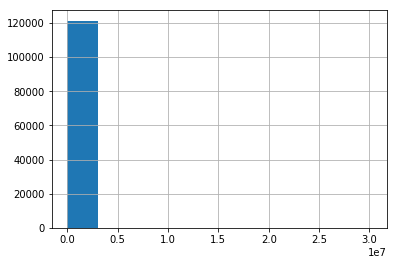

In [12]:
pageviews['views_in_2018'].hist()

#### There distribution of pageviews is "long-tail". It is much better to consider logarithm of pageviews.

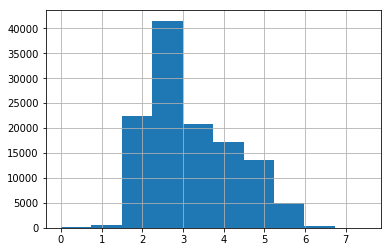

In [13]:
pageviews['log_views_in_2018'].hist()

'log_views_in_2018' has views for 6 last months of 2018. This data will be used for training ML model.

'log_views_in_2019' - first 6 month in 2019. These data will be used for validation of ML model

Join with "pages".

In [14]:
pages = pd.merge(pages, pageviews2018, on='en_page_id', how='left')
pages.head()

,uk_page_id,uk_page_title,en_page_id,categories,views_in_2018,views_in_2019,log_views_in_2018,log_views_in_2019
0,13,Географія,18963910.0,Географія МГЕ,409834.0,334405.0,5.612609,5.524274
1,584,Атом,902.0,Атоми Базові_поняття_фізики Основні_поняття_хімії,560559.0,440644.0,5.748622,5.644089
2,585,Мільярд,1136363.0,Натуральні_числа,454472.0,423483.0,5.657508,5.626837
3,586,Ядро,NaN,Багатозначні_терміни Всі_сторінки_неоднозначності Всі_сторінки_неоднозначності_статей,NaN,NaN,NaN,NaN
4,587,Мільйон,1045999.0,Натуральні_числа,NaN,NaN,NaN,NaN


# Word2Vec

We've pretrained word2vec model from http://lang.org.ua/en/models/
There is 'ubercorpus.lowercased.lemmatized.word2vec.300d.bz2' file

In [15]:
import numpy as np
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_multiple_whitespaces, remove_stopwords, stem_text
from gensim.models import Word2Vec, KeyedVectors
import pymorphy2
import tokenize_uk
import gensim
morph = pymorphy2.MorphAnalyzer(lang='uk')

/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [16]:
w2v_model = KeyedVectors.load_word2vec_format('ubercorpus.lowercased.lemmatized.word2vec.300d.bz2')
w2v_model.init_sims(replace=True)

### Tokenize categories 

In [17]:
cache = {}
def tokenize_categories(row):
    title = row['categories']
    title = title.replace('_', " ")
    if title in cache:
        return cache[title]
    else:
        tokenized = [morph.parse(t)[0].normal_form for t in tokenize_uk.tokenize_words(title)]
        cache[title] = tokenized
        return tokenized

In [18]:
pages['categories'] = pages.apply(tokenize_categories, axis=1)

In [19]:
pages.head()

,uk_page_id,uk_page_title,en_page_id,categories,views_in_2018,views_in_2019,log_views_in_2018,log_views_in_2019
0,13,Географія,18963910.0,"[географія, мге]",409834.0,334405.0,5.612609,5.524274
1,584,Атом,902.0,"[атом, базовий, поняття, фізик, основний, поняття, хімія]",560559.0,440644.0,5.748622,5.644089
2,585,Мільярд,1136363.0,"[натуральний, число]",454472.0,423483.0,5.657508,5.626837
3,586,Ядро,NaN,"[багатозначний, термін, весь, сторінка, неоднозначність, весь, сторінка, неоднозначність, стать]",NaN,NaN,NaN,NaN
4,587,Мільйон,1045999.0,"[натуральний, число]",NaN,NaN,NaN,NaN


## Models

Let's repeat it again. We are building a ML model which will predict pageviews (log of pageviews, actually) based on word2vec vector for categories.

We are trying 4 approaches for building vector representation for categories:

1. Average vector of all words that are in categories.
2. Weighted vector (based on IDF score) of all words that are in categories
3. Average vector of all catefories' words + UA page title
4. Weighted vector of all catefories' words + UA page title

### Evaluation

As mentioned above we train model based on 'log_views_in_2018' data (last 6 month of 2018) and check the prediciton performance using 'log_views_in_2019' data (first 6 month of 2019).

The measure of performance is MRSE for 'log_views_in_2019'.

In [20]:
def evaluate(reg_model, vectors_column):
    pc = pages.copy()
    X_test = np.array(list(map(lambda x: x.tolist(), pc[vectors_column])))
    y_pred = reg_model.predict(X_test)

    pc['2019_pred'] = y_pred
    final_test = pc[['log_views_in_2019', '2019_pred']]
    final_test = final_test[final_test['log_views_in_2019'].notnull()]

    
    print("MRSE: " + str(np.sqrt(mean_squared_error(final_test['log_views_in_2019'], final_test['2019_pred']))))

    plt.scatter(final_test['log_views_in_2019'], final_test['2019_pred'], alpha=0.01)
    plt.plot([1,7], [1,7], color='black');
    plt.xlim(1, 7)
    plt.ylim(1, 7)
    _=plt.show()

#### 1. Average vector of all words that are in categories.

In [21]:
def w2v(word):
    try:
        return w2v_model[word]
    except:
        return np.zeros(300)
        
    
def average_w3v(row):
    words = row['categories']
    s =  np.zeros(300)
    for word in words:
        s = np.add(s, w2v(word))
    return s    

In [22]:
pages['avg_cat_vector'] = pages.apply(average_w3v, axis=1)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

(121355, 300) (121355,)
MRSE: 0.39255121175461277


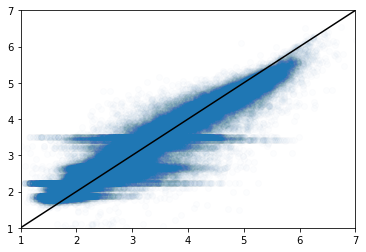

In [24]:
pc = pages.copy()
pc = pc[pc['log_views_in_2018'].notnull()]
y = pc['log_views_in_2018']
X = np.array(list(map(lambda x: x.tolist(), pc['avg_cat_vector'])))
print(X.shape, y.shape)
regr = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
regr.fit(X, y)
evaluate(regr, 'avg_cat_vector')

#### 2. Weighted vector (based on IDF score) of all words that are in categories

In [25]:
def calculate_idf_scores():
    all_words = {}
    for i, row in pages.iterrows():
        for word in row['categories']:
            if word in all_words:
                all_words[word] += 1
            else:
                all_words[word] = 1
    idf_scores = {}
    s = float(pages.shape[0])
    for word in all_words:
        idf_scores[word] = np.log(s/all_words[word])            
    return idf_scores  

In [26]:
idf_scores = calculate_idf_scores()

In [27]:
def weigthed_w3v(row):
    words = row['categories']
    s =  np.zeros(300)
    s_idf = 0
    for word in words:
        idf = idf_scores[word]
        s_idf += idf
        s = np.add(s, w2v(word) * idf)
    return s / s_idf

In [28]:
pages['weighted_cat_vector'] = pages.apply(weigthed_w3v, axis=1)

(121355, 300) (121355,)
MRSE: 0.38490519203755297


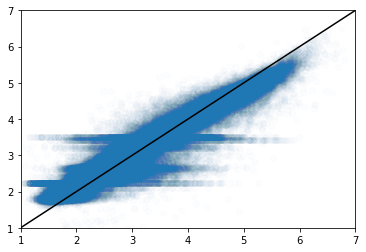

In [29]:
pc = pages.copy()
pc = pc[pc['log_views_in_2018'].notnull()]
y = pc['log_views_in_2018']
X = np.array(list(map(lambda x: x.tolist(), pc['weighted_cat_vector'])))
print(X.shape, y.shape)
regr = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
regr.fit(X, y)
evaluate(regr, 'weighted_cat_vector')

#### 3. Average vector of all catefories' words + UA page title

In [30]:
pages['categories'] = pages.apply(lambda row: row['categories'] + tokenize_categories({'categories': row['uk_page_title']}), axis=1)

In [31]:
pages['avg_cat_vector'] = pages.apply(average_w3v, axis=1)

(121355, 300) (121355,)
MRSE: 0.33382772502099817


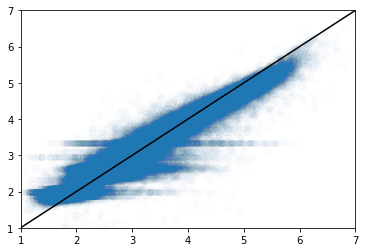

In [32]:
pc = pages.copy()
pc = pc[pc['log_views_in_2018'].notnull()]
y = pc['log_views_in_2018']
X = np.array(list(map(lambda x: x.tolist(), pc['avg_cat_vector'])))
print(X.shape, y.shape)
regr = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
regr.fit(X, y)
evaluate(regr, 'avg_cat_vector')

#### 4. Weighted vector of all catefories' words + UA page title

In [33]:
idf_scores = calculate_idf_scores()

In [34]:
pages['weighted_cat_vector'] = pages.apply(weigthed_w3v, axis=1)

(121355, 300) (121355,)
MRSE: 0.31887809096037684


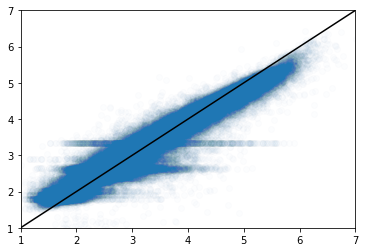

In [35]:
pc = pages.copy()
pc = pc[pc['log_views_in_2018'].notnull()]
y = pc['log_views_in_2018']
X = np.array(list(map(lambda x: x.tolist(), pc['weighted_cat_vector'])))
print(X.shape, y.shape)
regr = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
regr.fit(X, y)
evaluate(regr, 'weighted_cat_vector')

### ML model summary
| Features    | RMSE |
| --------------------------------------- | ----- |
| AVG(categories words)                   | 0.39  |
| WEIGHTED(categories words)              | 0.38  |
| AVG(categories words + page title)      | 0.33  |
| WEIGHTED(categories words + page title) | 0.32  |

## UA page ranking

In [36]:
X_test = np.array(list(map(lambda x: x.tolist(), pages['weighted_cat_vector'])))
y_pred = regr.predict(X_test)
pages['2019_pred'] = y_pred

In [38]:
pages_with_ranks = pages[pages['en_page_id'].isnull()][['uk_page_id', 'uk_page_title', 'categories', 'weighted_cat_vector', '2019_pred',]]
pages_with_ranks = pages_with_ranks.sort_values('2019_pred', axis=0, ascending=False)
#pages_with_ranks.head()

### Enter your query here

In [39]:
query = 'Наука про дані'  # Data Science
query = 'Добування даних' # Data Mining

In [40]:
words = tokenize_categories({'categories': query})
print(words)
words_vector = average_w3v({'categories': words})

['добування', 'даний']


### Calculating similarity for each page

It takes time. See LSH implementation below

In [41]:
def similarity(row):
    v = row['weighted_cat_vector']
    return np.dot(v, words_vector) / (np.linalg.norm(v) * np.linalg.norm(words_vector))

In [42]:
pages_with_ranks['sim'] = pages_with_ranks.apply(similarity, axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
pages_with_ranks = pages_with_ranks.sort_values('sim', axis=0, ascending=False)
pages_with_ranks[['uk_page_title', 'categories', 'sim']].head(10)

,uk_page_title,categories,sim
686491,Добування_даних,"[глибинний, аналіз, даний, зберігання, та, аналіз, корпоративний, даний, статистик, формальний, наука, добування, даний]",0.744226
605734,Перечередування_даних,"[даний, перечередування, даний]",0.733199
152199,Синхронізація_даних,"[база, даний, зберігання, даний, синхронізація, даний]",0.724777
70439,Редагування_даних,"[даний, обробка, інформація, редагування, даний]",0.681728
202383,Сховище_даних,"[база, даний, зберігання, та, аналіз, корпоративний, даний, сховище, даний]",0.679140
201829,Групування_даних,"[аналіз, даний, групування, даний]",0.678008
553893,Система_обробки_даних,"[даний, кібернетик, обробка, інформація, система, обробка, даний]",0.672028
352904,DRBD,"[зберігання, даний, drbd]",0.663334
416158,Схема_бази_даних,"[база, даний, моделювання, даний, управління, даний, схема, база, даний]",0.658570
752448,Знищення_даних,"[інформаційний, безпека, зберігання, даний, знищення, даний]",0.655210


### Using LSH

In [44]:
from sklearn.neighbors import LSHForest

In [45]:
X_train = np.array(list(map(lambda x: x.tolist(), pages_with_ranks['weighted_cat_vector'])))

In [46]:
lshf = LSHForest(n_estimators=100, random_state=42, n_neighbors=10)
lshf.fit(X_train)  

/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


LSHForest(min_hash_match=4, n_candidates=50, n_estimators=100, n_neighbors=10,
     radius=1.0, radius_cutoff_ratio=0.9, random_state=42)

In [47]:
_distances, indices = lshf.kneighbors([words_vector], n_neighbors=10)
neighbors = pages_with_ranks.iloc[indices[0]]
neighbors[['uk_page_id', 'uk_page_title', 'categories', 'sim']]

,uk_page_id,uk_page_title,categories,sim
686491,2468286,Добування_даних,"[глибинний, аналіз, даний, зберігання, та, аналіз, корпоративний, даний, статистик, формальний, наука, добування, даний]",0.744226
152199,481328,Синхронізація_даних,"[база, даний, зберігання, даний, синхронізація, даний]",0.724777
70439,211948,Редагування_даних,"[даний, обробка, інформація, редагування, даний]",0.681728
202383,692453,Сховище_даних,"[база, даний, зберігання, та, аналіз, корпоративний, даний, сховище, даний]",0.679140
201829,689136,Групування_даних,"[аналіз, даний, групування, даний]",0.678008
553893,1911422,Система_обробки_даних,"[даний, кібернетик, обробка, інформація, система, обробка, даний]",0.672028
352904,1221358,DRBD,"[зберігання, даний, drbd]",0.663334
416158,1464945,Схема_бази_даних,"[база, даний, моделювання, даний, управління, даний, схема, база, даний]",0.658570
752448,2701601,Знищення_даних,"[інформаційний, безпека, зберігання, даний, знищення, даний]",0.655210
722258,2572524,Фізична_модель_даних,"[моделювання, даний, управління, даний, фізичний, модель, даний]",0.654179
